# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load Images and Simple EDA

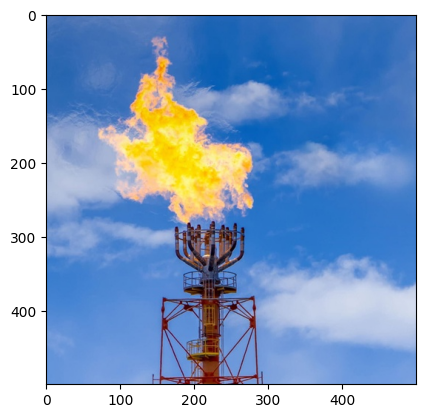

In [123]:
img = mpimg.imread('flare_example.jpg')
# Crop the image to the region of interest
img = img[:500, :500, :500]

fig, ax = plt.subplots()
ax.imshow(img);

In [11]:
# Convert image to pandas DataFrame
df = pd.DataFrame(img.reshape(-1, 3), columns=['r', 'g', 'b'])
df.head()

,r,g,b
0,83,121,186
1,81,119,184
2,80,118,181
3,80,118,181
4,80,120,182


# Pipelines or Custom Transformers Definition

In [13]:
# Define custom transformer from function to normalize from 0-255 to 0-1
from sklearn.base import BaseEstimator, TransformerMixin

class NormalizeImage(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X / 255

In [14]:
# Define Pipeline to kmeans cluster the image, but first normalize the image
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pipeline = Pipeline([
    ('normalize', NormalizeImage()),
    ('kmeans', KMeans(n_clusters=5, n_init=10, random_state=42))
])

# Training - Optimum num. of Clusters

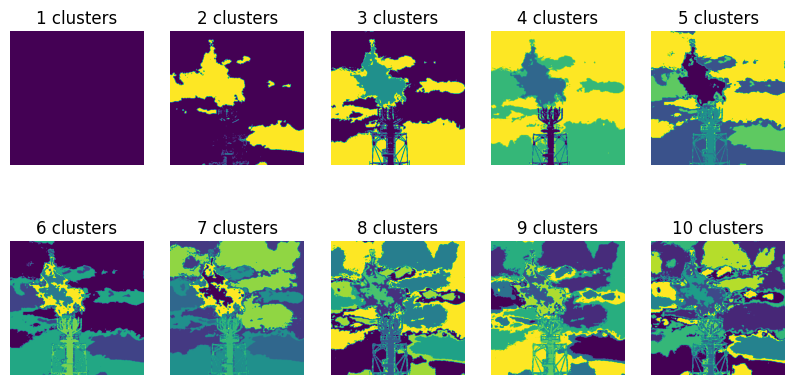

In [48]:
# Use Elbow method to find optimal number of clusters
inertia = []
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for k in range(1, 11):
    # fit to pipeline object
    kmeans = pipeline.set_params(kmeans__n_clusters=k, kmeans__n_init=10, kmeans__).fit(df)
    inertia.append(kmeans.named_steps['kmeans'].inertia_)

    # plot images with k clusters
    ax = axes[(k - 1) // 5, (k - 1) % 5]
    img = kmeans.predict(df).reshape(img.shape[0], img.shape[1])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{k} clusters')

Text(0, 0.5, 'Inertia')

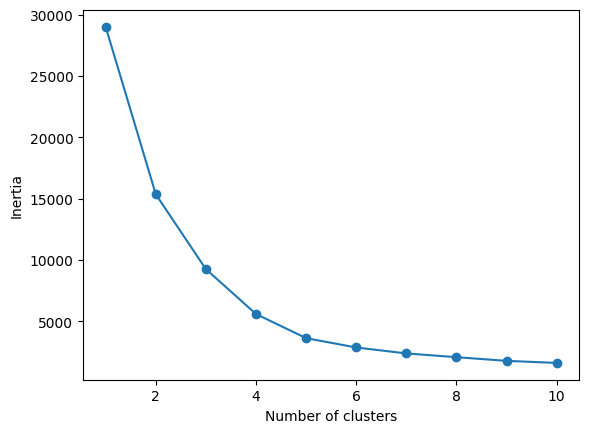

In [49]:
# Plot the inertia
fig, ax = plt.subplots()
ax.plot(range(1, 11), inertia, marker='o')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')

# Optimization - Best Distance with Custom KMeans Clustering

In [53]:
# Based on domain knowledge and elbow method, the optimal number of clusters is 3

In [119]:
# Defining a custom kmeans model to compare between distance metrics
class SimpleKMeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-6, distance_metric="euclidean"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.distance_metric = distance_metric
        self.centroids = None
        self.inertia_per_iter = []

    def _calculate_distance(self, X, centroids):
        if self.distance_metric == "euclidean":
            return np.linalg.norm(X - centroids, axis=1)
        elif self.distance_metric == "manhattan":
            return np.sum(np.abs(X - centroids), axis=1)
        elif self.distance_metric == "chebyshev":
            return np.max(np.abs(X - centroids), axis=1)
        else:
            raise ValueError("Distance metric not supported")

    def fit(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        np.random.seed(42)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            # Assigning each value to its closest cluster
            distances = np.array([self._calculate_distance(X, c) for c in self.centroids])
            labels = np.argmin(distances, axis=0)

            # Calculate new centriods and inertia
            new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])
            inertia = np.sum([np.sum(self._calculate_distance(X[labels == j], c)**2) for j, c in enumerate(new_centroids)])

            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break

            self.centroids = new_centroids
            self.inertia_per_iter.append(inertia)
        return self

    def predict(self, X):
        distances = np.array([self._calculate_distance(X, c) for c in self.centroids])
        return np.argmin(distances, axis=0)

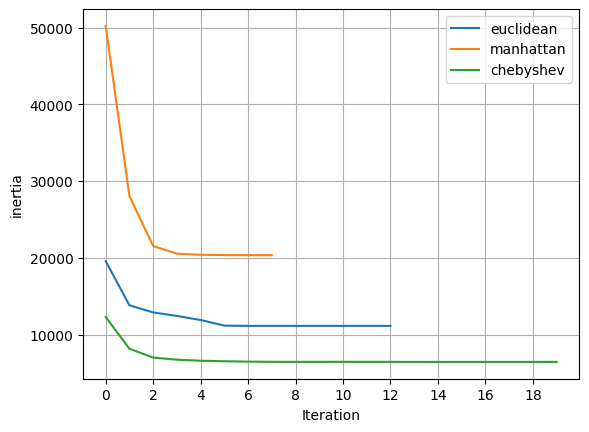

In [118]:
df_norm = NormalizeImage().fit_transform(df)

max_iter = 0
for distance in ["euclidean", "manhattan", "chebyshev"]:
    simpleKMeans = SimpleKMeans(n_clusters=3, distance_metric=distance)
    simpleKMeans.fit(df_norm)

    if len(simpleKMeans.inertia_per_iter) > max_iter:
        max_iter = len(simpleKMeans.inertia_per_iter)

    plt.plot(np.arange(len(simpleKMeans.inertia_per_iter)),simpleKMeans.inertia_per_iter, label=distance)
    plt.grid()

# make xticks integer with step of 2
plt.xticks(np.arange(0, max_iter, step=2))
plt.ylabel("inertia"); plt.xlabel("Iteration"); plt.legend()

In [140]:
def calculate_area(pred, range_min, range_max):
    x_range = slice(range_min, range_max)
    y_range = slice(range_min, range_max)

    cropped_region = pred[x_range, y_range]

    unique_clusters, counts = np.unique(cropped_region.reshape(-1), return_counts=True)
    most_common_cluster = unique_clusters[np.argmax(counts)]

    # return the percentage of the most common cluster in the whole pred
    return np.sum(pred == most_common_cluster) * 100 / pred.size


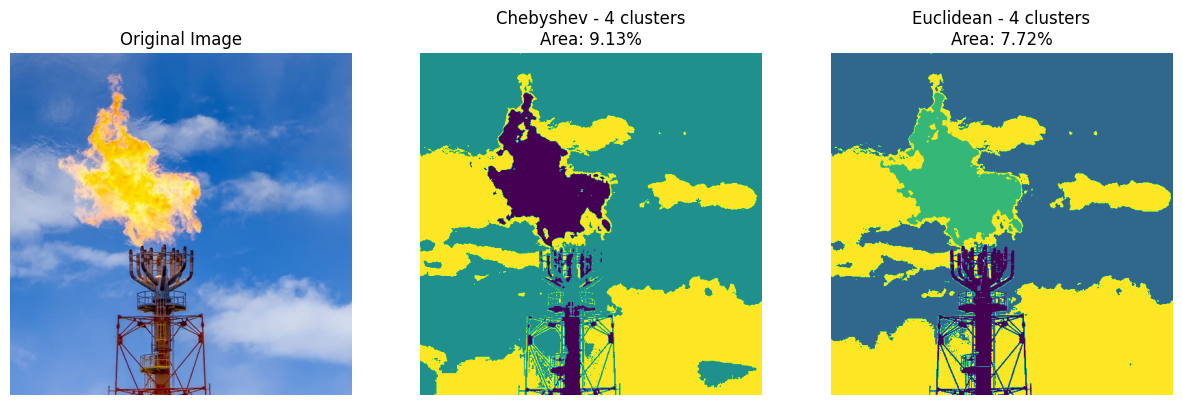

In [142]:
# Plot the image with 3 clusters side by side with the original image
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

simpleKMeans_cheb = SimpleKMeans(n_clusters=3, distance_metric="chebyshev")
simpleKMeans_cheb.fit(df_norm)
pred_cheb = simpleKMeans.predict(df_norm).reshape(img.shape[0], img.shape[1])
area_cheb = calculate_area(pred_cheb, 200, 226)
axes[1].imshow(pred_cheb)
axes[1].set_title('Chebyshev - 4 clusters\nArea: {:.2f}%'.format(area_cheb))
axes[1].axis('off')

simplekMeans_euc = SimpleKMeans(n_clusters=4, distance_metric="euclidean")
simplekMeans_euc.fit(df_norm)
pred_euc = simplekMeans_euc.predict(df_norm).reshape(img.shape[0], img.shape[1])
area_euc = calculate_area(pred_euc, 200, 226)
axes[2].imshow(pred_euc)
axes[2].set_title('Euclidean - 4 clusters\nArea: {:.2f}%'.format(area_euc))
axes[2].axis('off');

In [143]:
# score with silhouette coefficient
from sklearn.metrics import silhouette_score

silhouette_score(df_norm, pred_cheb.reshape(-1))